In [2]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np


def get_user_inputs():
    # Get file name
    file_name = input("Enter the file name (with extension, e.g., data.csv): ").strip()

    # Get list of time series IDs to forecast
    product_classes_input = input("Enter time series IDs to forecast, separated by commas: ").strip()
    product_classes_to_forecast = [id_.strip() for id_ in product_classes_input.split(",") if id_.strip()]

    # Get metric and validate
    metric = input("Enter the metric ('mape' or 'mse'): ").strip().lower()
    if metric not in ['mape', 'mse']:
        raise ValueError("Invalid metric. Must be 'mape' or 'mse'.")

    return file_name, product_classes_to_forecast, metric


def load_selected_timeseries(file_name: str, product_classes: list[str]) -> dict:
    # Load the CSV
    df = pd.read_csv(file_name)

    # Drop rows with missing essential values
    df.dropna(subset=["product_class", "Month", "sales_volume"], inplace=True)

    # Convert Month to datetime
    df["Month"] = pd.to_datetime(df["Month"], errors="coerce")
    df.dropna(subset=["Month"], inplace=True)

    # Filter for selected product_classes
    df = df[df["product_class"].isin(product_classes)]

    # Sort by date
    df = df.sort_values("Month")

    # Group and extract time series with product class as name
    time_series_dict = {
        product_class: group.set_index("Month")["sales_volume"].sort_index().rename(product_class)
        for product_class, group in df.groupby("product_class")
    }

    return time_series_dict


def check_seasonality_strength(ts: pd.Series, freq: int = 12, threshold: float = 0.5) -> str:
    # Check for enough data
    if len(ts) < 2 * freq:
        return "low"  # Not enough data to assess seasonality

    # Decompose the time series
    decomposition = seasonal_decompose(ts, model='additive', period=freq, extrapolate_trend='freq')

    # Compute strength of seasonality
    resid = decomposition.resid.dropna()
    seasonal = decomposition.seasonal.loc[resid.index]

    var_resid = np.var(resid)
    var_combined = np.var(resid + seasonal)

    if var_combined == 0:
        return "low"  # Avoid division by zero or flat series

    strength = 1 - (var_resid / var_combined)

    return "high" if strength >= threshold else "low"


def select_category(ts: pd.Series):
    """Determines to which category a time series belongs."""
    if len(ts) < 48:
        return "Category 1"
    elif check_seasonality_strength(ts) == "high" and (ts == 0).any():
        return "Category 2"
    elif check_seasonality_strength(ts) == "high" and (ts > 0).all():
        return "Category 3"
    elif check_seasonality_strength(ts) == "low" and (ts == 0).any():
        return "Category 4"
    else:
        return "Category 5"


#--------------------------------------------------------

categories = {
    'Category 1': ["naive", "drift"],
    'Category 2': ["naive", "ETS", "seasonal naive"],
    'Category 3': ["naive", "ARIMA", "ETS", "seasonal naive"],
    'Category 4': ["naive", "ARIMA", "drift", "mean"],
    'Category 5': ["naive", "ARIMA", "mean"]
}

file_name, product_classes_to_forecast, metric = get_user_inputs()
print(
    f"\nInputs received:\nFile: {file_name}\nProduct Classes to Forecast: {product_classes_to_forecast}\nMetric: {metric}")

ts_dict = load_selected_timeseries(file_name, product_classes_to_forecast)

for p_class, series in ts_dict.items():
    print(f"\nTime Series for {p_class}:")
    print(series)
    print(select_category(series))



Inputs received:
File: proj1_exampleinput.csv
Product Classes to Forecast: ['C1038', 'C2716', 'C6022']
Metric: mape

Time Series for C1038:
Month
2013-01-01    14212.0
2013-02-01    11424.0
2013-03-01    13432.0
2013-04-01    13078.0
2013-05-01    14356.0
2013-06-01    17142.0
2013-07-01    17377.0
2013-08-01    13449.0
2013-09-01    10185.0
2013-10-01    10455.0
2013-11-01    11432.0
2013-12-01    31873.0
2014-01-01    11997.0
2014-02-01     9787.0
2014-03-01     9037.0
2014-04-01     7863.0
2014-05-01     9472.0
2014-06-01    14928.0
2014-07-01    23856.0
2014-08-01    26547.0
2014-09-01    19960.0
2014-10-01    18338.0
2014-11-01    21364.0
2014-12-01    45749.0
2015-01-01    12426.0
2015-02-01    12485.0
2015-03-01    15622.0
2015-04-01    15469.0
2015-05-01    17695.0
2015-06-01    14329.0
2015-07-01    14573.0
2015-08-01    17184.0
2015-09-01    15990.0
2015-10-01    17959.0
2015-11-01    14598.0
2015-12-01    32284.0
2016-01-01    11957.0
2016-02-01    12719.0
2016-03-01    138

In [3]:
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import warnings
from statsforecast.models import AutoARIMA

def naive_forecast(series: pd.Series, horizon: int) -> np.ndarray:
    last_value = series.iloc[-1]
    return np.repeat(last_value, horizon)

def drift_forecast(series: pd.Series, horizon: int) -> np.ndarray:
    n = len(series)
    if n < 2:
        return np.repeat(series.iloc[-1], horizon)
    drift = (series.iloc[-1] - series.iloc[0]) / (n - 1)
    return series.iloc[-1] + drift * np.arange(1, horizon + 1)

def seasonal_naive_forecast(series: pd.Series, horizon: int, season_length: int = 12) -> np.ndarray:
    if len(series) < season_length:
        raise ValueError("Not enough data for seasonal naive forecast")
    last_season = series.iloc[-season_length:]
    reps = int(np.ceil(horizon / season_length))
    return np.tile(last_season.values, reps)[:horizon]

from statsmodels.tsa.holtwinters import ExponentialSmoothing

def ets_forecast(series: pd.Series, horizon: int) -> np.ndarray:
    model = ExponentialSmoothing(series, trend="add", seasonal="add", seasonal_periods=12)
    fitted_model = model.fit()
    return fitted_model.forecast(horizon)


# HERE IS AN ERROR!!!!
def arima_forecast(series: pd.Series, horizon: int) -> np.ndarray:
    series = series.dropna()
    series.index = pd.to_datetime(series.index)

    differenced = series.diff().dropna()
    df_sf = pd.DataFrame({
        "ds": differenced.index,
        "y": differenced.values
    })

    # Reset index to default integer index
    df_sf = df_sf.reset_index(drop=True)

    # Check data types
    print(df_sf.dtypes)
    print(df_sf.head())

    model = AutoARIMA()
    model.fit(df_sf)

    forecast_df = model.predict(horizon)
    forecast_diff = forecast_df['AutoARIMA'].values

    last_val = series.iloc[-1]
    forecast = np.cumsum(forecast_diff) + last_val

    return forecast


class HistoricAverageModel:
    def __init__(self):
        self.mean = None

    def fit(self, series: pd.Series):
        self.mean = series.mean()

    def forecast(self, horizon: int) -> np.ndarray:
        return np.repeat(self.mean, horizon)


In [4]:
arima_forecast()
print(df_sf.columns)  # Should be ['ds', 'y']
print(type(df_sf))    # Should be <class 'pandas.core.frame.DataFrame'>
print(df_sf.index)    # Should be RangeIndex, not DatetimeIndex
print(df_sf.dtypes)   # 'ds' datetime64[ns], 'y' float or int

TypeError: arima_forecast() missing 2 required positional arguments: 'series' and 'horizon'

In [5]:

def simulate_forecasting(ts_dict, categories, metric, forecast_horizon=12, retrain_every=6, eval_periods=24):
    all_results = []

    for ts_id, series in tqdm(ts_dict.items(), desc="Processing Time Series"):
        series = series.dropna()
        category = select_category(series)
        models = categories[category]

        if len(series) < 32:
            print(f"\nSkipping {ts_id} - only {len(series)} observations.")
            continue

        max_date = series.index.max()

        for i in range(0, eval_periods, retrain_every):
            train_end = max_date - relativedelta(months=(forecast_horizon + i))
            test_start = train_end + relativedelta(months=1)
            test_end = test_start + relativedelta(months=forecast_horizon - 1)

            train = series[:train_end]
            test = series[test_start:test_end]

            if len(test) < forecast_horizon or len(train) < 12:
                continue

            for model_name in models:
                try:
                    # Select prediction method
                    if model_name == "naive":
                        pred = naive_forecast(train, forecast_horizon)
                    elif model_name == "drift":
                        pred = drift_forecast(train, forecast_horizon)
                    elif model_name == "seasonal naive":
                        pred = seasonal_naive_forecast(train, forecast_horizon)
                    elif model_name == "ETS":
                        pred = ets_forecast(train, forecast_horizon)
                    elif model_name == "ARIMA":
                        pred = arima_forecast(train, forecast_horizon)
                    elif model_name == "HistoricAverage":
                        model = HistoricAverageModel()
                        model.fit(train)
                        pred = model.forecast(forecast_horizon)
                    else:
                        continue  # Skip unknown model
                except Exception as e:
                    print(f"Model {model_name} failed for {ts_id}: {e}")
                    pred = np.full(forecast_horizon, np.nan)

                # Evaluate
                pred = pd.Series(pred, index=test.index)
                if metric == "mape":
                    if (test == 0).any():
                        warnings.warn(f"MAPE warning for {ts_id} – true values contain zeros.")
                    error = np.mean(np.abs((test - pred) / np.maximum(test, 1e-8)))
                else:
                    error = np.mean((test - pred) ** 2)

                all_results.append({
                    "ts_id": ts_id,
                    "category": category,
                    "model": model_name,
                    "train_end": train_end.date(),
                    "test_start": test_start.date(),
                    "test_end": test_end.date(),
                    metric: error
                })

    return pd.DataFrame(all_results)


In [6]:
results_df = simulate_forecasting(
    ts_dict=ts_dict,
    categories=categories,
    metric=metric,
    forecast_horizon=12,
    retrain_every=6,
    eval_periods=24
)

results_df

Processing Time Series:   0%|          | 0/3 [00:00<?, ?it/s]/opt/anaconda3/envs/mysampleProject/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/mysampleProject/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/envs/mysampleProject/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/mysampleProject/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/envs/mysampleProject/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_m

ds    datetime64[ns]
y            float64
dtype: object
          ds       y
0 2013-02-01 -2788.0
1 2013-03-01  2008.0
2 2013-04-01  -354.0
3 2013-05-01  1278.0
4 2013-06-01  2786.0
Model ARIMA failed for C1038: 'DataFrame' object has no attribute 'dtype'
ds    datetime64[ns]
y            float64
dtype: object
          ds       y
0 2013-02-01 -2788.0
1 2013-03-01  2008.0
2 2013-04-01  -354.0
3 2013-05-01  1278.0
4 2013-06-01  2786.0
Model ARIMA failed for C1038: 'DataFrame' object has no attribute 'dtype'
ds    datetime64[ns]
y            float64
dtype: object
          ds       y
0 2013-02-01 -2788.0
1 2013-03-01  2008.0
2 2013-04-01  -354.0
3 2013-05-01  1278.0
4 2013-06-01  2786.0
Model ARIMA failed for C1038: 'DataFrame' object has no attribute 'dtype'
ds    datetime64[ns]
y            float64
dtype: object
          ds       y
0 2013-02-01 -2788.0
1 2013-03-01  2008.0
2 2013-04-01  -354.0
3 2013-05-01  1278.0
4 2013-06-01  2786.0
Model ARIMA failed for C1038: 'DataFrame' object h

,ts_id,category,model,train_end,test_start,test_end,mape
0,C1038,Category 3,naive,2016-07-01,2016-08-01,2017-07-01,0.226352
1,C1038,Category 3,ARIMA,2016-07-01,2016-08-01,2017-07-01,NaN
2,C1038,Category 3,ETS,2016-07-01,2016-08-01,2017-07-01,0.431226
3,C1038,Category 3,seasonal naive,2016-07-01,2016-08-01,2017-07-01,0.233362
4,C1038,Category 3,naive,2016-01-01,2016-02-01,2017-01-01,0.212497
5,C1038,Category 3,ARIMA,2016-01-01,2016-02-01,2017-01-01,NaN
6,C1038,Category 3,ETS,2016-01-01,2016-02-01,2017-01-01,0.208777
7,C1038,Category 3,seasonal naive,2016-01-01,2016-02-01,2017-01-01,0.156810
8,C1038,Category 3,naive,2015-07-01,2015-08-01,2016-07-01,0.141168
9,C1038,Category 3,ARIMA,2015-07-01,2015-08-01,2016-07-01,NaN


In [7]:
def evaluate_models(results_df: pd.DataFrame, ts_dict: dict, metric: str):
    """
    Evaluate model performance and select the best model per time series.
    Warn if MAPE is used on series with zero values.
    """
    if results_df.empty:
        print("No results to evaluate.")
        return pd.DataFrame()

    # Warn about MAPE with zero values
    if metric == 'mape':
        zero_series = [
            ts_id for ts_id, ts in ts_dict.items() if (ts == 0).any()
        ]
        if zero_series:
            print("WARNING: MAPE used on series that contain zero values:")
            print("Affected time series IDs:", zero_series)

    # Calculate average performance per model per time series
    avg_performance = (
        results_df.groupby(['ts_id', 'model'])[metric]
        .mean()
        .reset_index()
        .rename(columns={metric: f'avg_{metric}'})
    )

    # Select best model (lowest error) for each time series
    best_models = (
        avg_performance.loc[
            avg_performance.groupby('ts_id')[f'avg_{metric}'].idxmin()
        ]
        .reset_index(drop=True)
    )

    print("\nBest model per time series based on lowest average error:")
    print(best_models)

    return best_models

best_models_df = evaluate_models(results_df, ts_dict, metric)


Best model per time series based on lowest average error:
   ts_id  model  avg_mape
0  C1038  naive  0.199065
1  C2716  naive  0.051749
2  C6022  drift  0.212629


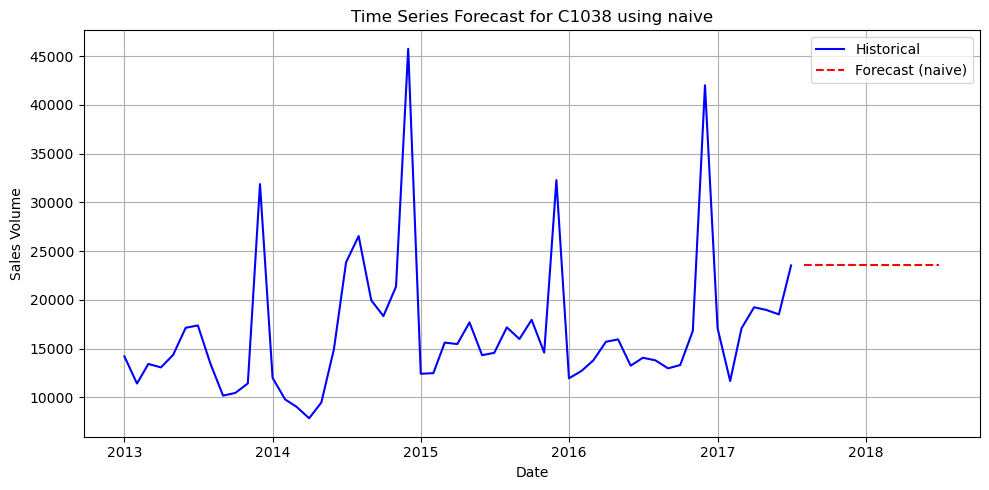

Saved forecast for C1038 using naive to forecast_outputs/C1038_forecast_naive.csv


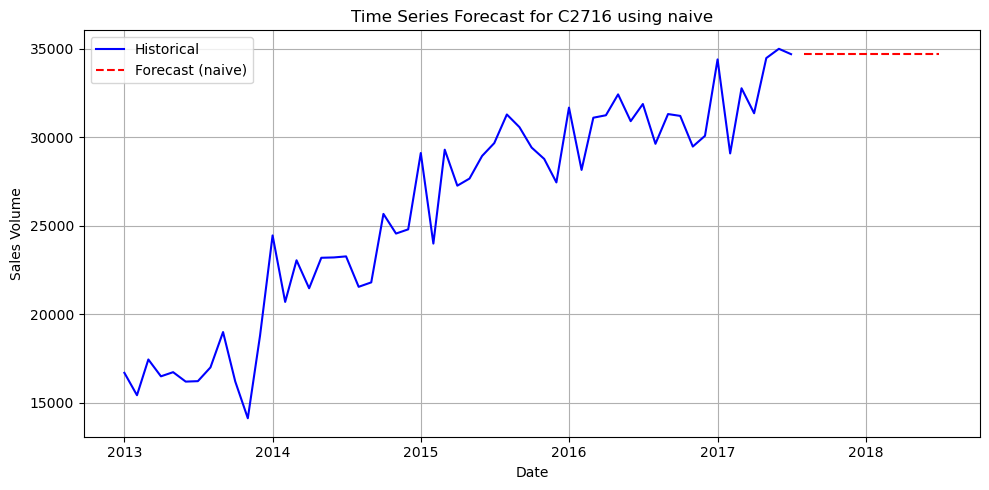

Saved forecast for C2716 using naive to forecast_outputs/C2716_forecast_naive.csv


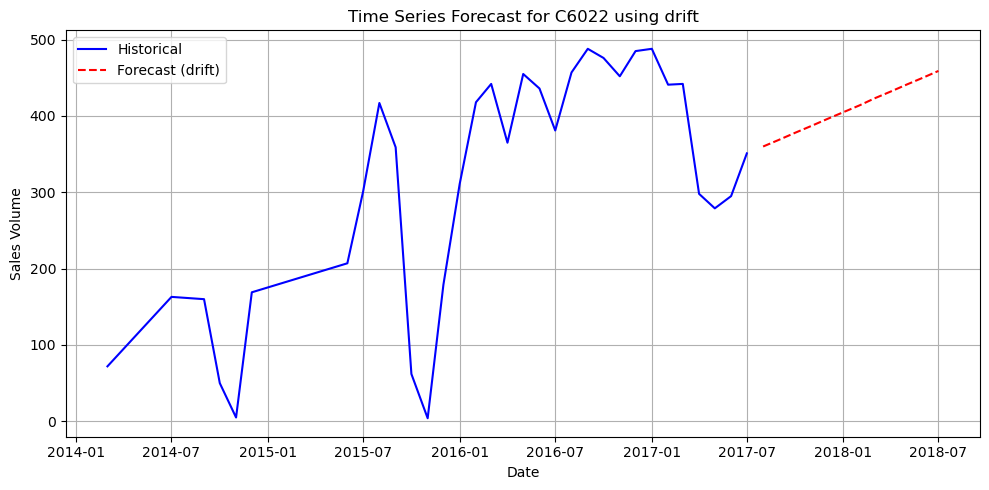

Saved forecast for C6022 using drift to forecast_outputs/C6022_forecast_drift.csv


In [8]:
import matplotlib.pyplot as plt
import os

def forecast_and_plot_best_models(best_models_df, ts_dict, forecast_horizon=12, output_dir="forecast_outputs"):
    """
    Forecast using the best model per time series, plot the results,
    and save forecasted values to CSV files.
    """
    os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist

    for idx, row in best_models_df.iterrows():
        ts_id = row['ts_id']
        best_model = row['model']
        series = ts_dict[ts_id].dropna()

        try:
            # Forecast using the appropriate model
            if best_model == "naive":
                forecast = naive_forecast(series, forecast_horizon)
            elif best_model == "drift":
                forecast = drift_forecast(series, forecast_horizon)
            elif best_model == "seasonal naive":
                forecast = seasonal_naive_forecast(series, forecast_horizon)
            elif best_model == "ETS":
                forecast = ets_forecast(series, forecast_horizon)
            elif best_model == "ARIMA":
                forecast = arima_forecast(series, forecast_horizon)
            elif best_model == "HistoricAverage":
                model = HistoricAverageModel()
                model.fit(series)
                forecast = model.forecast(forecast_horizon)
            else:
                print(f"Unknown model '{best_model}' for {ts_id}, skipping.")
                continue

            # Prepare forecast index
            last_date = series.index[-1]
            forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS')
            forecast_series = pd.Series(forecast, index=forecast_index)

            # Plotting
            plt.figure(figsize=(10, 5))
            plt.plot(series.index, series.values, label='Historical', color='blue')
            plt.plot(forecast_series.index, forecast_series.values, label=f'Forecast ({best_model})', color='red', linestyle='--')
            plt.title(f'Time Series Forecast for {ts_id} using {best_model}')
            plt.xlabel("Date")
            plt.ylabel("Sales Volume")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            # Save forecast to CSV
            forecast_df = forecast_series.reset_index()
            forecast_df.columns = ["Month", "Forecast"]
            output_path = os.path.join(output_dir, f"{ts_id}_forecast_{best_model}.csv")
            forecast_df.to_csv(output_path, index=False)
            print(f"Saved forecast for {ts_id} using {best_model} to {output_path}")

        except Exception as e:
            print(f"Error forecasting {ts_id} with {best_model}: {e}")

forecast_and_plot_best_models(best_models_df, ts_dict, forecast_horizon=12)
